# DeepWeeds — Transfer Learning and Fine-Tuning

We classify weed species using an ImageNet-pretrained **EfficientNet-B0** with 2 strategies:
- **Strategy A**: unfreeze last 2 EfficientNet stages (`blocks[-2:]`) + classifier head
- **Strategy B**: fine tune the full model with a lower learning rate alpha



In [1]:
# Colab setup
!pip -q install timm kagglehub scikit-learn pandas


In [2]:
import os
import random
import shutil
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder

import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

import matplotlib.pyplot as plt

# Config
seed = 42
bs = 64
img_sz = 224
num_workers = 2

ep_a = 8
ep_b = 9
lr_a = 1e-3
lr_b = 1e-5
wd = 1e-4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", dev)


Device: cuda


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imsparsh/deepweeds")

print("Path to dataset files:", path)


100%|██████████| 470M/470M [00:05<00:00, 93.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/deepweeds/versions/2


In [ ]:
p = Path(path)
print("Top-level:", [x.name for x in p.iterdir()][:30])

# Build/point to ImageFolder dirs: train/ and val/
work = Path("/content/deepweeds_imgfolder")
tr_dir = work / "train"
va_dir = work / "val"

img_ext = {".jpg", ".jpeg", ".png", ".bmp"}

def n_class_dirs_with_imgs(d: Path):
    if not d.exists() or not d.is_dir():
        return 0
    n = 0
    for c in d.iterdir():
        if not c.is_dir():
            continue
        if any(f.suffix.lower() in img_ext for f in c.rglob("*")):
            n += 1
    return n

def has_class_subdirs(d: Path, min_classes=2):
    return n_class_dirs_with_imgs(d) >= min_classes

img_dir = p / "images"
lab_dir = p / "labels"

built = False

def safe_name(s: str):
    s = str(s)
    s = s.strip()
    s = "".join(ch if (ch.isalnum() or ch in "-_.") else "_" for ch in s)
    return s[:80] if s else "unknown"

def pick_label_csv():
    cands = []
    if lab_dir.exists():
        cands += list(lab_dir.rglob("*.csv"))
    cands += list(p.rglob("*.csv"))

    for f in cands:
        try:
            df = pd.read_csv(f)
        except Exception:
            continue
        if df.shape[0] < 10 or df.shape[1] < 2:
            continue
        ok = False
        for c in df.columns:
            s = df[c].astype(str).str.lower()
            if s.str.contains(r"\.(jpg|jpeg|png|bmp)$", regex=True).any():
                ok = True
                break
        if ok:
            return f, df
    return None, None

def find_fname_col(df):
    for c in df.columns:
        s = df[c].astype(str).str.lower()
        if (s.str.contains(r"\.(jpg|jpeg|png|bmp)$", regex=True).mean() > 0.5):
            return c
    for c in df.columns:
        s = df[c].astype(str).str.lower()
        if s.str.contains(r"\.(jpg|jpeg|png|bmp)$", regex=True).any():
            return c
    return None

def find_lab_col(df, fname_col):
    cols = [c for c in df.columns if c != fname_col]
    for pref in ["label", "species", "class", "weed", "target", "category", "name"]:
        for c in cols:
            if pref in str(c).lower():
                return c
    best = None
    best_u = 10**18
    for c in cols:
        u = df[c].nunique(dropna=True)
        if 1 < u < best_u:
            best_u = u
            best = c
    return best
if img_dir.exists() and lab_dir.exists():
    lab_csv, df = pick_label_csv()
    if lab_csv is None:
        raise FileNotFoundError("Found images/ and labels/ but no usable labels CSV")

    fn_c = find_fname_col(df)
    lb_c = find_lab_col(df, fn_c)
    if fn_c is None or lb_c is None:
        raise ValueError(f"Could not infer filename/label columns in: {lab_csv}. Columns: {list(df.columns)}")

    df = df[[fn_c, lb_c]].dropna()
    df[fn_c] = df[fn_c].astype(str)
    df[lb_c] = df[lb_c].astype(str)

    fps = []
    for fn in df[fn_c].tolist():
        fn = fn.strip()
        fp = img_dir / fn
        if not fp.exists():
            fp = p / fn
        fps.append(fp if fp.exists() else None)

    df["fp"] = fps
    df = df[df["fp"].notna()].copy()

    if work.exists():
        shutil.rmtree(work)
    tr_dir.mkdir(parents=True, exist_ok=True)
    va_dir.mkdir(parents=True, exist_ok=True)

    for lab, g in df.groupby(lb_c):
        files = g["fp"].tolist()
        random.shuffle(files)
        k = max(1, int(0.2 * len(files)))

        lab = safe_name(lab)
        out_tr = tr_dir / lab
        out_va = va_dir / lab
        out_tr.mkdir(parents=True, exist_ok=True)
        out_va.mkdir(parents=True, exist_ok=True)

        for f in files[:k]:
            shutil.copy2(f, out_va / f.name)
        for f in files[k:]:
            shutil.copy2(f, out_tr / f.name)

    print("Built ImageFolder from labels:", lab_csv)
    built = True
if not built:
    tr_cand = list(p.rglob("train"))
    va_cand = list(p.rglob("val")) + list(p.rglob("valid")) + list(p.rglob("validation"))

    src_tr, src_va = None, None
    for d in tr_cand:
        if has_class_subdirs(d):
            src_tr = d
            break
    for d in va_cand:
        if has_class_subdirs(d):
            src_va = d
            break

    if src_tr and src_va:
        print("Found existing ImageFolder dirs:")
        print("- train:", src_tr)
        print("- val:", src_va)

        work.mkdir(parents=True, exist_ok=True)

        if tr_dir.is_symlink():
            tr_dir.unlink()
        elif tr_dir.exists():
            shutil.rmtree(tr_dir)

        if va_dir.is_symlink():
            va_dir.unlink()
        elif va_dir.exists():
            shutil.rmtree(va_dir)

        try:
            os.symlink(src_tr, tr_dir, target_is_directory=True)
            os.symlink(src_va, va_dir, target_is_directory=True)
            print("Using symlinks in:", work)
        except Exception as e:
            print("Symlink failed, copying instead:", e)
            shutil.copytree(src_tr, tr_dir)
            shutil.copytree(src_va, va_dir)

    else:
        base = None
        best_n = 0
        for d in [p] + [x for x in p.rglob("*") if x.is_dir()]:
            n = n_class_dirs_with_imgs(d)
            if n > best_n:
                best_n = n
                base = d

        if base is None or best_n < 2:
            raise FileNotFoundError("Could not find class folders with images under: " + str(p))

        print("Building train/val split from:", base, "| classes:", best_n)

        if work.exists():
            shutil.rmtree(work)
        tr_dir.mkdir(parents=True, exist_ok=True)
        va_dir.mkdir(parents=True, exist_ok=True)

        for c in sorted([x for x in base.iterdir() if x.is_dir()]):
            imgs = [f for f in c.rglob("*") if f.suffix.lower() in img_ext]
            if len(imgs) == 0:
                continue

            random.shuffle(imgs)
            k = max(1, int(0.2 * len(imgs)))

            out_tr = tr_dir / c.name
            out_va = va_dir / c.name
            out_tr.mkdir(parents=True, exist_ok=True)
            out_va.mkdir(parents=True, exist_ok=True)

            for f in imgs[:k]:
                shutil.copy2(f, out_va / f.name)
            for f in imgs[k:]:
                shutil.copy2(f, out_tr / f.name)

print("Train dir:", tr_dir)
print("Val dir:", va_dir)


Top-level: ['images', 'labels']


/tmp/ipython-input-3862198544.py:52: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if s.str.contains(r"\.(jpg|jpeg|png|bmp)$", regex=True).any():
/tmp/ipython-input-3862198544.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (s.str.contains(r"\.(jpg|jpeg|png|bmp)$", regex=True).mean() > 0.5):


Built ImageFolder from labels: /root/.cache/kagglehub/datasets/imsparsh/deepweeds/versions/2/labels/test_subset1.csv
Train dir: /content/deepweeds_imgfolder/train
Val dir: /content/deepweeds_imgfolder/val


In [5]:
tr_cls = sorted([d.name for d in tr_dir.iterdir() if d.is_dir()])
va_cls = sorted([d.name for d in va_dir.iterdir() if d.is_dir()])
print("Train classes:", tr_cls[:20])
print("Val classes:", va_cls[:20])
print("Train exists:", tr_dir.exists(), "Val exists:", va_dir.exists())

if len(set(tr_cls) & set(va_cls)) < 2:
    raise ValueError("Bad split: val has too few classes. Re-run dataset prep cell.")


Train classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8']
Val classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8']
Train exists: True Val exists: True


## Why EfficientNet-B0 (ImageNet pretrained)?

EfficientNet-B0 gives strong accuracy with low compute. For outdoor plant photos (varying lighting, backgrounds, scale), its pretrained features transfer well and it fine tunes quickly in Colab.



In [6]:
# Transforms (train vs val)
tfm_tr = transforms.Compose([
    transforms.RandomResizedCrop(img_sz, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

tfm_va = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_sz),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

# Datasets + loaders
ds_tr = ImageFolder(tr_dir, transform=tfm_tr)
ds_va = ImageFolder(va_dir, transform=tfm_va)

n_cls = len(ds_tr.classes)
print("n_cls:", n_cls)
print("classes:", ds_tr.classes)

cnt = np.bincount(ds_tr.targets)
w = 1.0 / np.maximum(cnt, 1)
sw = w[np.array(ds_tr.targets)]
sw = torch.as_tensor(sw, dtype=torch.double)
sam = WeightedRandomSampler(sw, num_samples=len(sw), replacement=True)

tr_dl = DataLoader(ds_tr, batch_size=bs, sampler=sam, num_workers=num_workers, pin_memory=True)
va_dl = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)

xb, yb = next(iter(tr_dl))
print("batch:", xb.shape, yb.shape)


n_cls: 9
classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8']
batch: torch.Size([64, 3, 224, 224]) torch.Size([64])


In [ ]:
def mk_m(n_cls: int):
    m = timm.create_model("efficientnet_b0", pretrained=True, num_classes=n_cls)
    return m

# no weights update
def freeze_all(m):
    for p in m.parameters():
        p.requires_grad = False

# all weights update
def unfreeze_all(m):
    for p in m.parameters():
        p.requires_grad = True

# same shit but for last 2 blocks and head
def unfreeze_last2_and_head(m):
    if not hasattr(m, "blocks"):
        raise AttributeError("Model has no 'blocks' attribute")

    n = len(m.blocks)
    keep = {f"blocks.{n-2}", f"blocks.{n-1}", "classifier"}

    for name, p in m.named_parameters():
        if any(name.startswith(k) for k in keep):
            p.requires_grad = True
        else:
            p.requires_grad = False

# to prove that we are freezing the correct stuff
def n_trainable(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

def run_ep(m, dl, opt, loss_fn, is_train=True, scaler=None):
    if is_train:
        m.train()
    else:
        m.eval()

    tot = 0.0
    n = 0

    for xb, yb in dl:
        # move to device
        xb = xb.to(dev, non_blocking=True)
        yb = yb.to(dev, non_blocking=True)

        # zero grads

        if is_train:
            opt.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    # forward pass
                    out = m(xb)
                    # calculate loss
                    loss = loss_fn(out, yb)
            else:
                # forward pass
                out = m(xb)
                # calculate loss
                loss = loss_fn(out, yb)

        if is_train:
            if scaler is not None:
                #backward pass
                scaler.scale(loss).backward()
                #update weights
                scaler.step(opt)
                #update scale for next iteration
                scaler.update()
            else:
                #backward pass
                loss.backward()
                #update weights
                opt.step()

        bsz = xb.size(0)
        tot += loss.item() * bsz
        n += bsz
    
    # calcluate average loss
    return tot / max(1, n)

@torch.no_grad()
def eval_m(m, dl):
    m.eval()
    # y true and p predicated
    yt, yp = [], []
    for xb, yb in dl:
        xb = xb.to(dev, non_blocking=True)
        # foward pass
        out = m(xb)
        # convert to class prediction, take argmax and move to cpu
        pr = out.argmax(1).cpu().numpy().tolist()
        # append to list
        yp += pr
        yt += yb.numpy().tolist()

    # calculate accuracy
    acc = accuracy_score(yt, yp)
    p, r, f1, _ = precision_recall_fscore_support(yt, yp, average="macro", zero_division=0)
    cm = confusion_matrix(yt, yp)
    return {"acc": float(acc), "p_macro": float(p), "r_macro": float(r), "f1_macro": float(f1), "cm": cm}

def sd_to_cpu(sd):
    return {k: v.detach().cpu() for k, v in sd.items()}

def show_cm(cm, names):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    t = np.arange(len(names))
    plt.xticks(t, names, rotation=45, ha="right")
    plt.yticks(t, names)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Trainable params (A): 2755109


/tmp/ipython-input-1192018483.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if dev.type == "cuda" else None
/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 1/8 | tr_loss 1.5623 | va_loss 1.9804 | acc 0.4628 | f1 0.4683 | best_f1 0.4683


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 2/8 | tr_loss 0.9425 | va_loss 1.2971 | acc 0.6576 | f1 0.5975 | best_f1 0.5975


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 3/8 | tr_loss 0.7779 | va_loss 1.3234 | acc 0.6504 | f1 0.6273 | best_f1 0.6273


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 4/8 | tr_loss 0.7228 | va_loss 1.1781 | acc 0.7292 | f1 0.6534 | best_f1 0.6534


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 5/8 | tr_loss 0.6795 | va_loss 1.1611 | acc 0.7264 | f1 0.6836 | best_f1 0.6836


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 6/8 | tr_loss 0.6469 | va_loss 1.0837 | acc 0.7464 | f1 0.7003 | best_f1 0.7003


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 7/8 | tr_loss 0.6198 | va_loss 1.0083 | acc 0.7722 | f1 0.7212 | best_f1 0.7212


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 8/8 | tr_loss 0.6141 | va_loss 1.0531 | acc 0.7736 | f1 0.7313 | best_f1 0.7313

Strategy A metrics (best ep = 8):
{'acc': 0.7736389684813754, 'p_macro': 0.7414906297830903, 'r_macro': 0.7612669297817719, 'f1_macro': 0.7313390107478012}


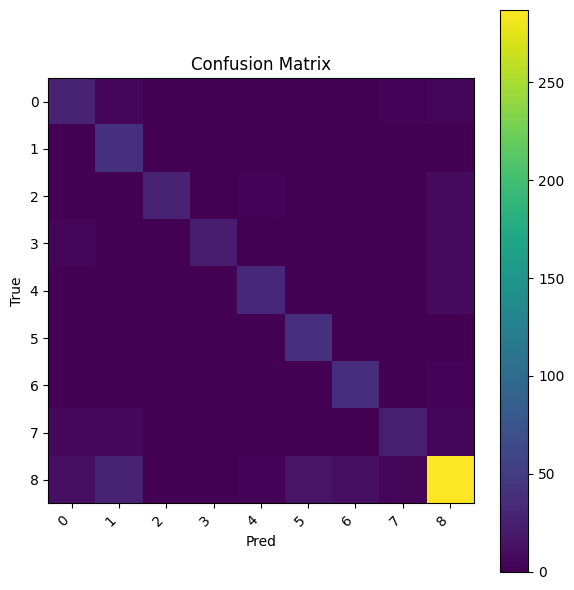

In [8]:
# Strategy A: partial fine-tune (last 2 blocks + head)
m_a = mk_m(n_cls).to(dev)
unfreeze_last2_and_head(m_a)
print("Trainable params (A):", n_trainable(m_a))

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
opt_a = torch.optim.AdamW([p for p in m_a.parameters() if p.requires_grad], lr=lr_a, weight_decay=wd)

scaler = torch.cuda.amp.GradScaler() if dev.type == "cuda" else None

best_f1 = -1.0
best_ep = -1
best_sd = None
best_met = None

for e in range(ep_a):
    tr_loss = run_ep(m_a, tr_dl, opt_a, loss_fn, is_train=True, scaler=scaler)
    va_loss = run_ep(m_a, va_dl, opt_a, loss_fn, is_train=False, scaler=None)
    met = eval_m(m_a, va_dl)

    if met["f1_macro"] > best_f1:
        best_f1 = met["f1_macro"]
        best_ep = e + 1
        best_sd = sd_to_cpu(m_a.state_dict())
        best_met = met

    print(f"A | ep {e+1}/{ep_a} | tr_loss {tr_loss:.4f} | va_loss {va_loss:.4f} | acc {met['acc']:.4f} | f1 {met['f1_macro']:.4f} | best_f1 {best_f1:.4f}")

m_a.load_state_dict(best_sd)
met_a = best_met
print(f"\nStrategy A metrics (best ep = {best_ep}):")
print({k: v for k, v in met_a.items() if k != "cm"})
show_cm(met_a["cm"], ds_tr.classes)


Trainable params (B): 4019077


/tmp/ipython-input-2840134274.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if dev.type == "cuda" else None
/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 1/9 | tr_loss 3.8058 | va_loss 3.1605 | acc 0.2221 | f1 0.1684 | best_f1 0.1684


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 2/9 | tr_loss 3.1361 | va_loss 2.8982 | acc 0.2350 | f1 0.1935 | best_f1 0.1935


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 3/9 | tr_loss 2.6882 | va_loss 2.7831 | acc 0.2464 | f1 0.2194 | best_f1 0.2194


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 4/9 | tr_loss 2.3482 | va_loss 2.6769 | acc 0.2693 | f1 0.2554 | best_f1 0.2554


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 5/9 | tr_loss 2.1694 | va_loss 2.6549 | acc 0.2679 | f1 0.2696 | best_f1 0.2696


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 6/9 | tr_loss 2.0454 | va_loss 2.6279 | acc 0.2822 | f1 0.2834 | best_f1 0.2834


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 7/9 | tr_loss 1.8991 | va_loss 2.5686 | acc 0.2908 | f1 0.2945 | best_f1 0.2945


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 8/9 | tr_loss 1.8417 | va_loss 2.5477 | acc 0.3052 | f1 0.3154 | best_f1 0.3154


/tmp/ipython-input-14929716.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 9/9 | tr_loss 1.7590 | va_loss 2.4538 | acc 0.3209 | f1 0.3324 | best_f1 0.3324

Strategy B metrics (best ep = 9):
{'acc': 0.3209169054441261, 'p_macro': 0.32494367507332006, 'r_macro': 0.4533397272951064, 'f1_macro': 0.3324108699918708}


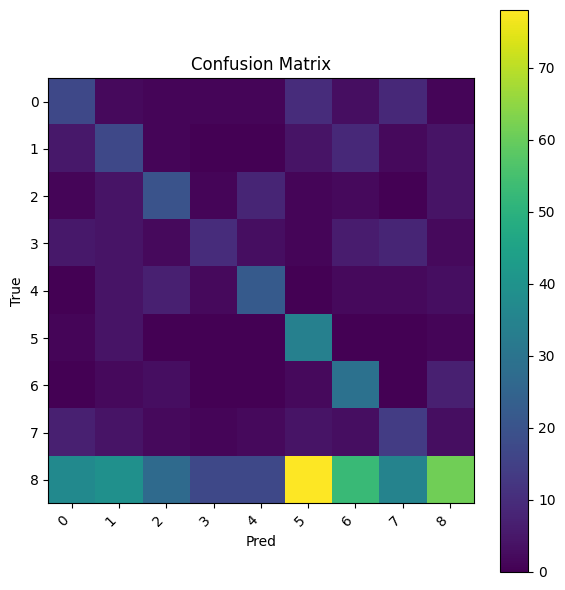

In [9]:
# Strategy B: full fine-tune (lower LR)
m_b = mk_m(n_cls).to(dev)
unfreeze_all(m_b)
print("Trainable params (B):", n_trainable(m_b))

opt_b = torch.optim.AdamW(m_b.parameters(), lr=lr_b, weight_decay=wd)

scaler = torch.cuda.amp.GradScaler() if dev.type == "cuda" else None

best_f1 = -1.0
best_ep = -1
best_sd = None
best_met = None

for e in range(ep_b):
    tr_loss = run_ep(m_b, tr_dl, opt_b, loss_fn, is_train=True, scaler=scaler)
    va_loss = run_ep(m_b, va_dl, opt_b, loss_fn, is_train=False, scaler=None)
    met = eval_m(m_b, va_dl)

    if met["f1_macro"] > best_f1:
        best_f1 = met["f1_macro"]
        best_ep = e + 1
        best_sd = sd_to_cpu(m_b.state_dict())
        best_met = met

    print(f"B | ep {e+1}/{ep_b} | tr_loss {tr_loss:.4f} | va_loss {va_loss:.4f} | acc {met['acc']:.4f} | f1 {met['f1_macro']:.4f} | best_f1 {best_f1:.4f}")

m_b.load_state_dict(best_sd)
met_b = best_met
print(f"\nStrategy B metrics (best ep = {best_ep}):")
print({k: v for k, v in met_b.items() if k != "cm"})
show_cm(met_b["cm"], ds_tr.classes)


In [10]:
# Compare Strategy A vs Strategy B
rows = []
for name, met in [("A (partial)", met_a), ("B (full)", met_b)]:
    rows.append({
        "strategy": name,
        "acc": met["acc"],
        "p_macro": met["p_macro"],
        "r_macro": met["r_macro"],
        "f1_macro": met["f1_macro"],
    })

cmp = pd.DataFrame(rows)
cmp


,strategy,acc,p_macro,r_macro,f1_macro
0,A (partial),0.773639,0.741491,0.761267,0.731339
1,B (full),0.320917,0.324944,0.453340,0.332411
